## How bad is the scaling estimate for $\Phi_{Tr}$ for profiles other than linear?

Comparison between estimated tracer flux onto the shelf through the canyon and the real deal.

$\Phi_{Tr}=\Phi \bar{C}$

where $\frac{\Phi}{WUD_h} = 0.9\mathcal{F}_w^{3/2}R_o^{1/2}(1-1.21S_E)^3+0.07$, $\mathcal{F}_w=R_w/(0.9+R_w)$, $R_w=U/fW$, $S_E=sN/f(\mathcal{F}_w/R_o)^{1/2}$.

And, $\bar{C}$ is 
$\frac{\bar{C}}{C_0}= 0.04\frac{\partial_zC}{2} (H_s+H_r) + 1.0$

where
$\frac{\partial_zC}{\partial_zC_0}= 6.3\frac{Z+Z_{dif}}{H_s}+1.0$

and 

$Z_{dif}=(t(\kappa_{can}-\kappa_{bg}))^{1/2}$


In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Constants and scales

# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh = 97.5 # head depth
Hr = 132.0 # rim depth at DnS
No = 5.5E-3
f = 9.66E-5
kv = 1E-5
kbg = 1E-5
t = 6 # days
U = 0.35 # m/s

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)


In [4]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracers_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracers_fileNoC)

time = state.variables['T']
depth = grid.variables['RC']

In [5]:
fileBAR = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run01.csv')
fileBARNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/HCW_TrMass_BARKLEY_run02.csv') 

fileLWR = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/HCW_TrMass_CNTDIFF_LOW_SR_7Tr_run01.csv')
fileLWRNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/HCW_TrMass_CNTDIFF_LOW_SR_7Tr_run02.csv') 

dfBAR = pd.read_csv(fileBAR)
dfBARnoc = pd.read_csv(fileBARNoC)

dfLWR = pd.read_csv(fileLWR)
dfLWRnoc = pd.read_csv(fileLWRNoC)                

In [6]:
import canyon_records_tracers
records = canyon_records_tracers.main()

In [7]:
labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']

labels_Para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours_Para = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7'] 


(-180, -100)

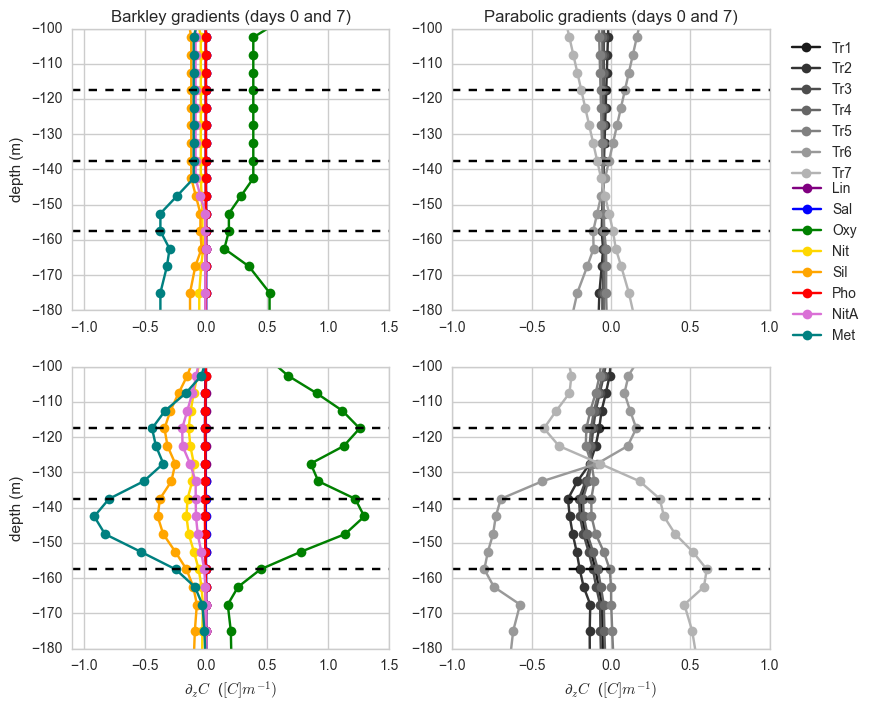

In [8]:
fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(9,8))

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_dTrdz = np.empty(8)
Bar_inidTrdz = np.empty(8)
Bar_dTrdz_std = np.empty(8)
       
Par_dTrdz = np.empty(7)
Par_inidTrdz = np.empty(7)
Par_dTrdz_std = np.empty(8)

record = records[0]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Bark, labels_Bark):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
    ax1.plot(df[key0][:],depth[1:-1],'o-',color=col,label=lab)
    ax3.plot(df[keys[3]][:],depth[1:-1],'-o',color=col,label=lab)
    
    Bar_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Bar_inidTrdz[ii] = df[key0][30]
    Bar_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    ii = ii+1
    
record = records[1]
ii = 0
for tracer,col,lab in zip(record.tracerList, colours_Para, labels_Para):
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTrdz_Tr%s_%s_%s.csv' 
                     %(tracer,record.name,stname))
    df = pd.read_csv(filename1)

    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
 
    ax2.plot(df[key0][:],depth[1:-1],'o-',color=col,label=lab)
    ax4.plot(df[keys[3]][:],depth[1:-1],'o-',color=col,label=lab)
    
    Par_dTrdz[ii] = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    Par_inidTrdz[ii] = df[key0][30]
    Par_dTrdz_std[ii] = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
   
    ii = ii+1
    
ax3.set_xlabel('$\partial_z{C}$  ($[C]m^{-1})$')
ax3.set_ylabel('depth (m)')
ax1.set_ylabel('depth (m)')
ax1.set_title('Barkley gradients (days 0 and 7)')

ax4.set_xlabel('$\partial_z{C}$  ($[C]m^{-1})$')
ax2.set_title('Parabolic gradients (days 0 and 7)')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax1.legend(bbox_to_anchor=(2.52,0.5),ncol=1, columnspacing=0.1)

ax2.axhline(depth[23],linestyle='--',color='k')
ax1.axhline(depth[23],linestyle='--',color='k')
ax2.axhline(depth[27],linestyle='--',color='k')
ax1.axhline(depth[27],linestyle='--',color='k')
ax1.axhline(depth[31],linestyle='--',color='k')
ax2.axhline(depth[31],linestyle='--',color='k')
ax4.axhline(depth[23],linestyle='--',color='k')
ax3.axhline(depth[23],linestyle='--',color='k')
ax4.axhline(depth[27],linestyle='--',color='k')
ax3.axhline(depth[27],linestyle='--',color='k')
ax3.axhline(depth[31],linestyle='--',color='k')
ax4.axhline(depth[31],linestyle='--',color='k')

ax1.set_xlim(-1.1,1.5)
ax1.set_ylim(-180,-100)
ax2.set_xlim(-1,1)
ax2.set_ylim(-180,-100)
ax3.set_xlim(-1.1,1.5)
ax3.set_ylim(-180,-100)
ax4.set_xlim(-1,1)
ax4.set_ylim(-180,-100)

In [9]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

Bar_maxTr = np.empty(8)
Bar_stdTr = np.empty(8)
Bar_TrSB = np.empty(8)
Bar_Ctop = np.empty(8)

Par_maxTr = np.empty(7)
Par_stdTr = np.empty(7)
Par_TrSB = np.empty(7)
Par_Ctop = np.empty(7)

record = records[0]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
    
    
    Bar_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Bar_TrSB[ii] = maxd0
    Bar_Ctop[ii] = df[key0][0]
    ii=ii+1
    
record = records[1]
ii = 0
for tracer in record.tracerList:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/%s_profile_%s_%s.csv' 
                 % (tracer,record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:30])   
    maxd5 = np.mean(df[keys[1]][25:30])   
    maxd6 = np.mean(df[keys[2]][25:30]) 
    maxd7 = np.mean(df[keys[3]][25:30])  
    maxd8 = np.mean(df[keys[4]][25:30])  
    maxd0 = df[key0][29]
   
    
    Par_maxTr[ii] = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_stdTr[ii] = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    Par_TrSB[ii] = maxd0
    Par_Ctop[ii] = df[key0][0]
    ii=ii+1


In [10]:
Mass_Bark = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07','TrMassHCW08']
Mass_Para = ['TrMassHCW01','TrMassHCW02','TrMassHCW03','TrMassHCW04',
             'TrMassHCW05','TrMassHCW06','TrMassHCW07']



In [11]:
Z = ((f*U*F(Ro(U,f,R))*L)**(0.5))/No
Zdif = np.sqrt(t*3600*24*(kv-kbg))
    
Se = (s*No)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
HA2013=(U*W*Dh(f,L,No))*((0.91*(F(Ro(U,f,W))**(3/2))*(Ro(U,f,L)**(1/2))*((1-1.21*Se)**3))+0.07)

## How well does the scaling do?

Tracer	Phi err (%)	C err (%)	dTr0	TrSB
Tr1 	61.4	67.9	-0.050	13.6
Tr2 	65.6	70.2	-0.059	13.6
Tr3 	62.0	68.3	-0.051	13.6
Tr4 	60.8	67.5	-0.049	13.6
Tr5 	58.1	65.9	-0.043	13.6
Tr6 	81.8	80.1	-0.113	13.6
Tr7 	22.1	16.4	0.013	150.1
Lin 	10.3	2.5	-0.002	32.2
Sal 	11.1	1.6	-0.001	33.9
Oxy 	270.0	300.6	0.186	104.1
Nit 	29.0	45.7	-0.031	32.6
Sil 	51.1	69.3	-0.047	47.6
Pho 	11.2	0.4	-0.001	2.2
NitA 	0.6	13.7	-0.007	27.7
Met 	359.3	389.6	-0.375	17.5


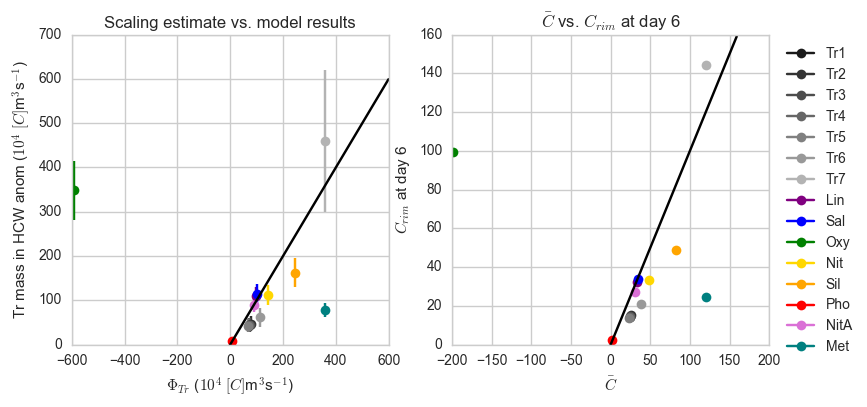

In [13]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

print ("\t".join(['Tracer', 'Phi err (%)', 'C err (%)', 'dTr0', 'TrSB']))

rec = records[0]

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scale_PhiTr/PhiTr
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')
    err_C = Capprox/C
    
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.1f\t%1.3f\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, dTr0, Co)]))
    


for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    err_phi = scale_PhiTr/PhiTr
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')
    err_C = Capprox/C
    print ("%s" % (lab), "\t".join(['\t%1.1f\t%1.1f\t%1.3f\t%1.1f' % (abs(1-err_phi)*100, abs(1-err_C)*100, dTr0, Co)]))
   

   
ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Tr mass in HCW anom ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Scaling estimate vs. model results')
#ax1.set_ylim(0,500)
#ax1.set_xlim(0,500)
ax1.plot(np.arange(0,600,1),np.arange(0,600,1),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,160,1),np.arange(0,160,1),'-k')

(0, 55)

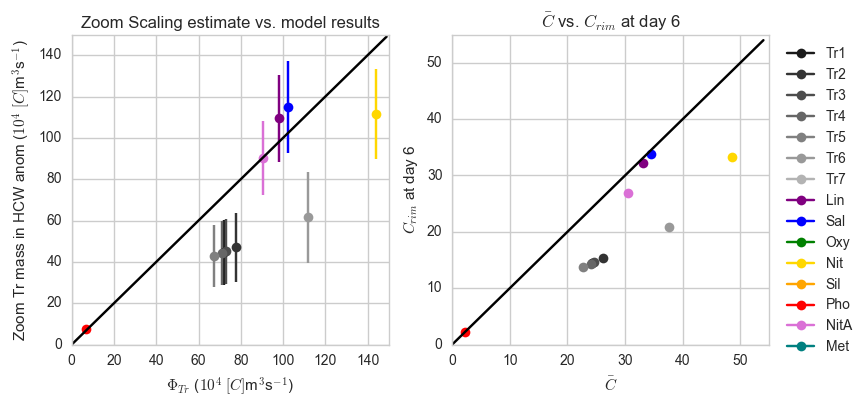

In [39]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.00)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    
    ax1.errorbar(scale_PhiTr/1E4, PhiTr/1E4, yerr=PhiTr_std/1E4, color=col, label=lab, marker='o')
    ax2.plot(Capprox, C, color=col, label=lab, marker='o')

ax1.set_xlabel(r'$\Phi_{Tr}$ ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_ylabel('Zoom Tr mass in HCW anom ($10^4$ $[C]$m$^{3}$s$^{-1}$)')
ax1.set_title('Zoom Scaling estimate vs. model results')
ax1.set_ylim(0,150)
ax1.set_xlim(0,150)
ax1.plot(np.arange(0,150,1),np.arange(0,150,1),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel('$C_{rim}$ at day 6')
ax2.set_title(r'$\bar{C}$ vs. $C_{rim}$ at day 6')
ax2.plot(np.arange(0,55,1),np.arange(0,55,1),'-k')
ax2.set_ylim(0,55)
ax2.set_xlim(0,55)


Form this plot with a gigantic scale it is clear that our scaling does a pretty bad approximation for oxygen, methane (largest negative curvature) for both tracer flux and concentration near the rim. Also, the model comparison for concentration that I took ($C_{rim}$ at day 6) may not be very fair but it seems to be in good agreement of what happens for $\Phi_{Tr}$.

I will take the profiles that satisfy:

$$|(1-\frac{\Phi_{Tr}}{\Phi_{model}}|100\%\le 20\%$$

as cases where the model does a decent job (within 20\% of model result).
|
Oxygen is terrible because it decreases with depth and the scaling cannot deal with that so far.

Also, the flux is overestimated by the scaling, except for linear and salinity.

In general, cases where the scale for tracer transport fails has to do with the scaling failing to approximate the characteristic concentration. 

A curious thing is that scaling for the linear profile Tr1 fails. So the problem does not have to do with curvature but with the initial vertical gradient. Scaling for the characteristic concentration gets worse with increasing $\partial_zCo$. See next plot. 

## Scaling performs worse with increasing initial vertical gradient (?)

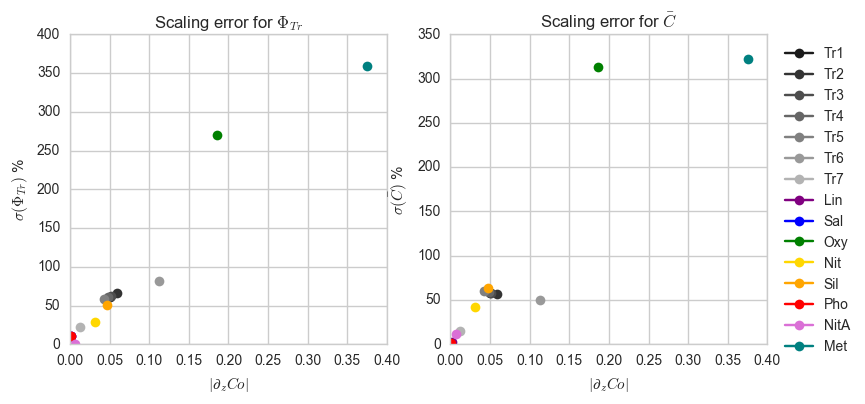

In [14]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot(abs(dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot(abs(dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    
  

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot(abs(dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot(abs(dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    

   
ax1.set_xlabel(r'$|\partial_zCo|$')
ax1.set_ylabel('$\sigma(\Phi_{Tr})$ %')
ax1.set_title('Scaling error for $\Phi_{Tr}$')
#ax1.set_ylim(0,500)
#ax1.set_xlim(0,500)

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$|\partial_zCo|$')
ax2.set_ylabel(r'$\sigma(\bar{C})$ %')
ax2.set_title(r'Scaling error for $\bar{C}$')


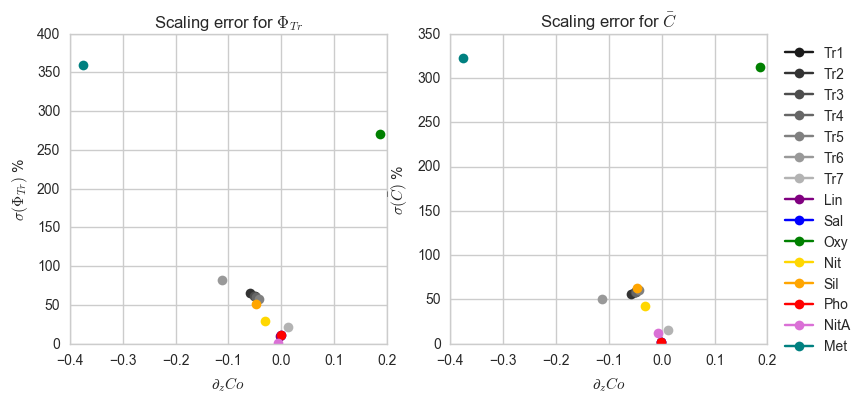

In [15]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot((dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot((dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    
  

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot((dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot((dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    

   
ax1.set_xlabel(r'$\partial_zCo$')
ax1.set_ylabel('$\sigma(\Phi_{Tr})$ %')
ax1.set_title('Scaling error for $\Phi_{Tr}$')
#ax1.set_ylim(0,500)
#ax1.set_xlim(0,500)

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\partial_zCo$')
ax2.set_ylabel(r'$\sigma(\bar{C})$ %')
ax2.set_title(r'Scaling error for $\bar{C}$')


(0, 0.114)

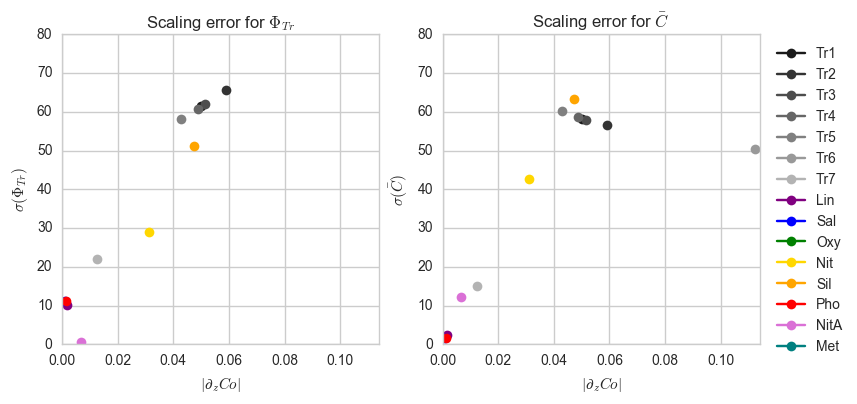

In [16]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot(abs(dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot(abs(dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    
  

for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot(abs(dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot(abs(dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    

   
ax1.set_xlabel(r'$|\partial_zCo|$')
ax1.set_ylabel('$\sigma(\Phi_{Tr})$')
ax1.set_title('Scaling error for $\Phi_{Tr}$')
ax1.set_ylim(0,80)
ax1.set_xlim(0,0.114)

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$|\partial_zCo|$')
ax2.set_ylabel(r'$\sigma(\bar{C})$')
ax2.set_title(r'Scaling error for $\bar{C}$')
ax2.set_ylim(0,80)
ax2.set_xlim(0,0.114)


(-0.15, 0.05)

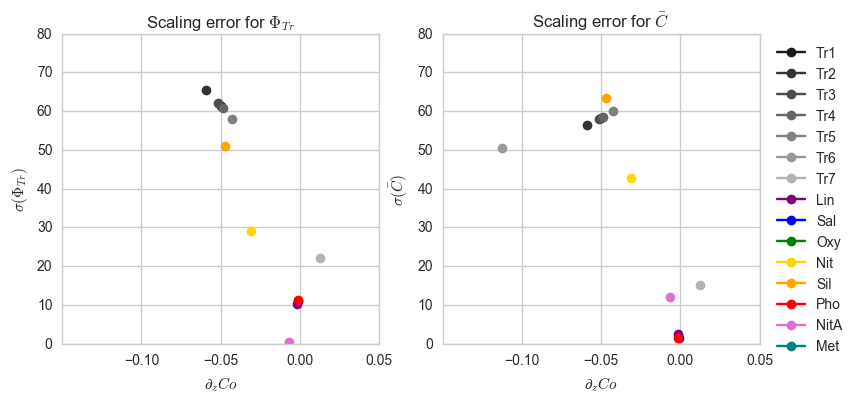

In [17]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for TrMass, dTr0,Co,C, lab, col in zip(Mass_Para,Par_inidTrdz[:],Par_TrSB[:],Par_maxTr[:],labels_Para,colours_Para):
    
    mass_can_eff = dfLWR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot((dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot((dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')
    
for TrMass, dTr0, Co,C, lab, col in zip(Mass_Bark,Bar_inidTrdz,Bar_TrSB,Bar_maxTr,labels_Bark,colours_Bark):
    
    mass_can_eff = dfBAR[TrMass]
    PhiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    PhiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,15)]))
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    scale_PhiTr = HA2013*Capprox
    err_phi = scale_PhiTr/PhiTr
    ax1.plot((dTr0),(abs(1-err_phi))*100 , color=col, label=lab, marker='o')
    err_C = Capprox/C
    ax2.plot((dTr0), abs(1-err_C)*100, color=col, label=lab, marker='o')

ax1.set_xlabel(r'$\partial_zCo$')
ax1.set_ylabel('$\sigma(\Phi_{Tr})$')
ax1.set_title('Scaling error for $\Phi_{Tr}$')
ax1.set_ylim(0,80)
ax1.set_xlim(-0.15,0.05)

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\partial_zCo$')
ax2.set_ylabel(r'$\sigma(\bar{C})$')
ax2.set_title(r'Scaling error for $\bar{C}$')
ax2.set_ylim(0,80)
ax2.set_xlim(-0.15,0.05)


It is pretty clear that my scaling is now working for larger (in absolute value) initial vertical gradients. Still, why is the error in parabolic tracers decreasing with  the initial vertical gradient? Is it the curvature?

I need to find out which one am I getting wrong, the squeezing/stretching ($\partial_zC$) or the linear approximation to get $\bar{C}$?

## What is the problem, the squeezing or the linear approximation?

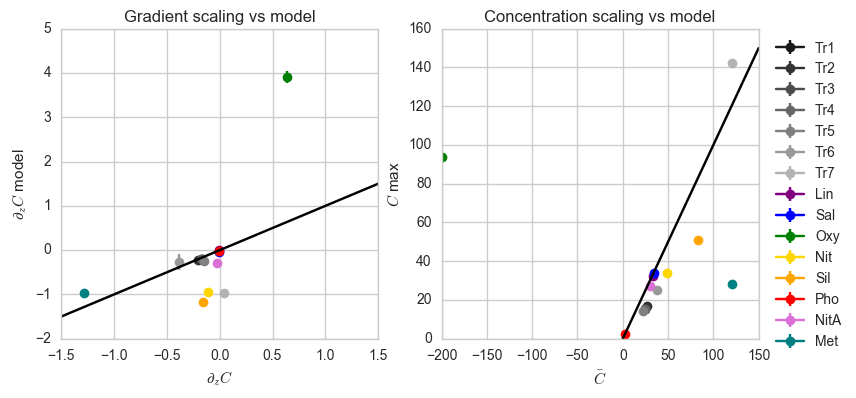

In [18]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for dTrMod, dTr0, std, Co, C, stdTr, lab, col in zip(Par_dTrdz,Par_inidTrdz,Par_dTrdz_std,Par_TrSB,Par_maxTr,Par_stdTr,
                                                     labels_Para,colours_Para):
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    ax1.errorbar(-dTrdz, dTrMod , yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(Capprox, C, yerr=stdTr, color=col, label=lab, marker='o')
    
for dTrMod, dTr0, std, Co, C, stdTr, lab, col in zip(Bar_dTrdz, Bar_inidTrdz,Bar_dTrdz_std,Bar_TrSB,Bar_maxTr,Bar_stdTr,
                                                     labels_Bark,colours_Bark):
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    ax1.errorbar(-dTrdz, dTrMod, yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(Capprox, C, yerr=stdTr, color=col, label=lab, marker='o')
 

   
ax1.set_xlabel(r'$\partial_zC$')
ax1.set_ylabel('$\partial_zC$ model')
ax1.set_title('Gradient scaling vs model')
#ax1.set_ylim(0,80)
#ax1.set_xlim(-0.15,0.05)
ax1.plot(np.linspace(-1.5,1.5,100),np.linspace(-1.5,1.5,100),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel(r'$C$ max')
ax2.set_title(r'Concentration scaling vs model')
#ax2.set_ylim(0,80)
#ax2.set_xlim(-0.15,0.05)
ax2.plot(np.linspace(0,150,100),np.linspace(0,150,100),'-k')


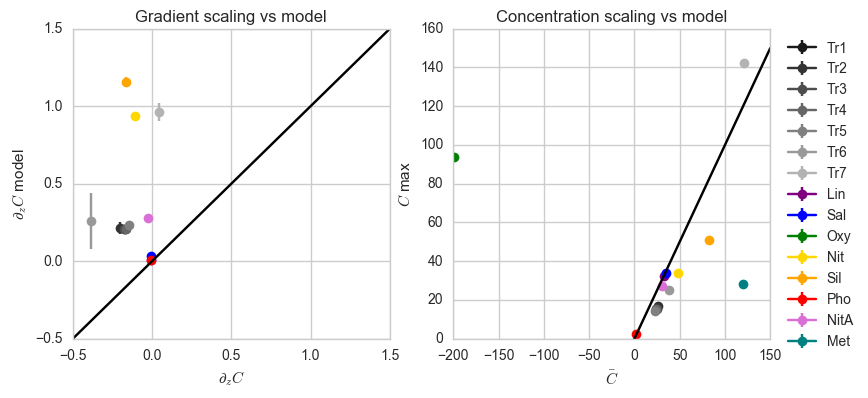

In [19]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(9,4))

rec = records[0]

for dTrMod, dTr0, std, Co, C, stdTr, lab, col in zip(Par_dTrdz,Par_inidTrdz,Par_dTrdz_std,Par_TrSB,Par_maxTr,Par_stdTr,
                                                     labels_Para,colours_Para):
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    ax1.errorbar(-dTrdz, -dTrMod , yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(Capprox, C, yerr=stdTr, color=col, label=lab, marker='o')
    
for dTrMod, dTr0, std, Co, C, stdTr, lab, col in zip(Bar_dTrdz, Bar_inidTrdz,Bar_dTrdz_std,Bar_TrSB,Bar_maxTr,Bar_stdTr,
                                                     labels_Bark,colours_Bark):
    
    dTrdz = -dTr0*(6.3*(((Z+Zdif)/Hs))+1.0)
    Capprox=((0.04*(dTrdz*(Hh+132.0)/2.0))+1.0)*Co
    ax1.errorbar(-dTrdz, -dTrMod, yerr=std, color=col, label=lab, marker='o')
    ax2.errorbar(Capprox, C, yerr=stdTr, color=col, label=lab, marker='o')
 

   
ax1.set_xlabel(r'$\partial_zC$')
ax1.set_ylabel('$\partial_zC$ model')
ax1.set_title('Gradient scaling vs model')
ax1.set_ylim(-0.5,1.5)
ax1.set_xlim(-0.5,1.5)
ax1.plot(np.linspace(-1.5,1.5,100),np.linspace(-1.5,1.5,100),'-k')

ax2.legend(bbox_to_anchor=(1.3,1),ncol=1, columnspacing=0.1)
ax2.set_xlabel(r'$\bar{C}$')
ax2.set_ylabel(r'$C$ max')
ax2.set_title(r'Concentration scaling vs model')
#ax2.set_ylim(0,150)
#ax2.set_xlim(0,150)
ax2.plot(np.linspace(0,150,100),np.linspace(0,150,100),'-k')
